In [1]:
import scarlet
import galsim
from astropy import wcs as WCS
import time
import galsim_compare_tools as gct

In [2]:
%pylab inline
# Setup: declaring survey properties, loading catalog and making sure we have pretty colorbars
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'

HST, EUCLID, WFIRST, HSC, LSST = gct.load_surveys()

cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')

mymap = 'gnuplot2'#mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

Populating the interactive namespace from numpy and matplotlib


Scarlet timing
CPU times: user 85.8 ms, sys: 17.4 ms, total: 103 ms
Wall time: 63 ms
Galsim timing
CPU times: user 106 ms, sys: 31.7 ms, total: 137 ms
Wall time: 24.2 ms
scarlet SDR:  30.107396029599684
galsim SDR:  29.732632664606186


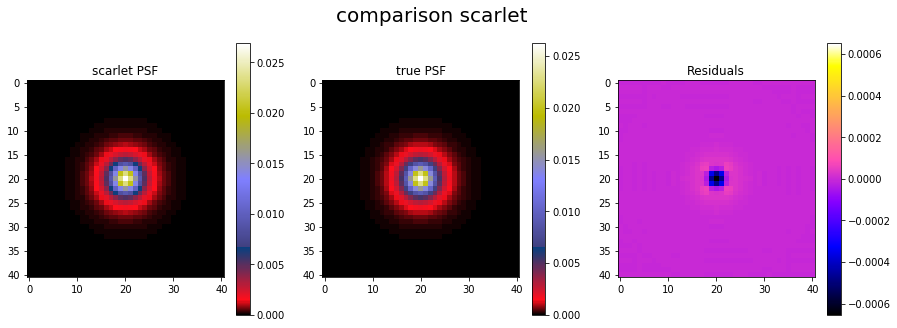

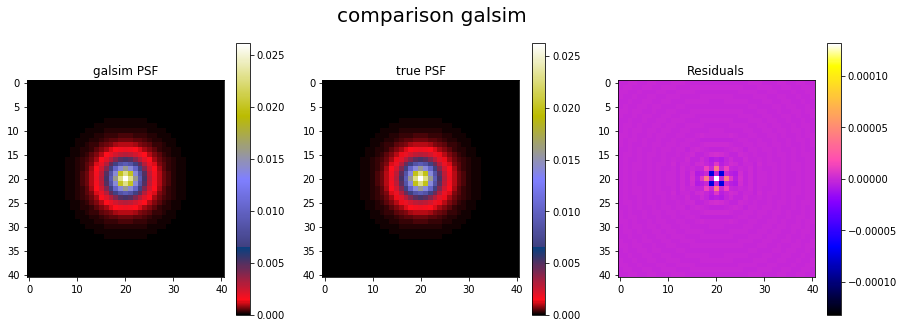

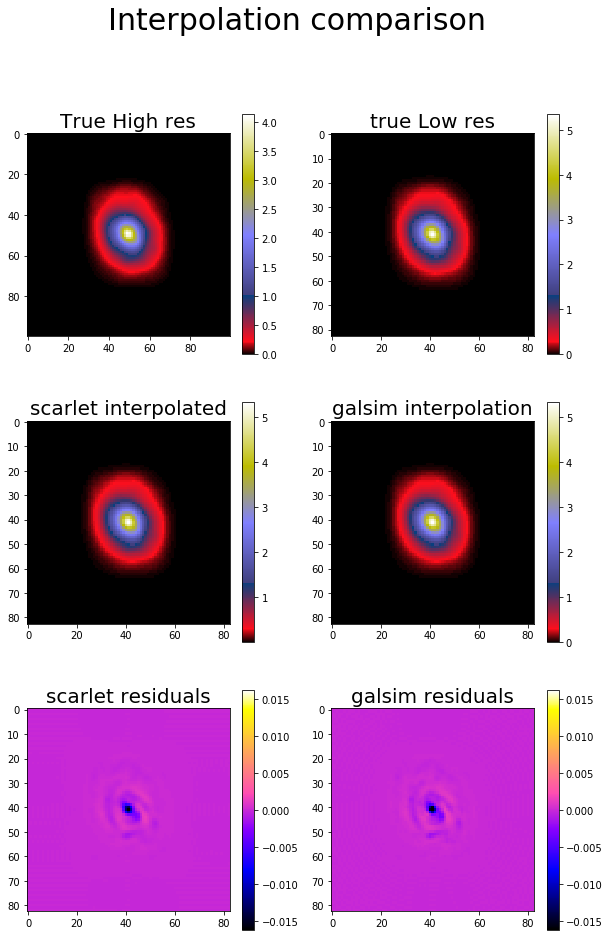

Scarlet timing
CPU times: user 197 ms, sys: 68.9 ms, total: 266 ms
Wall time: 115 ms
Galsim timing
CPU times: user 38.4 ms, sys: 97.7 ms, total: 136 ms
Wall time: 31.3 ms
scarlet SDR:  26.670755589104584
galsim SDR:  26.476176018549474


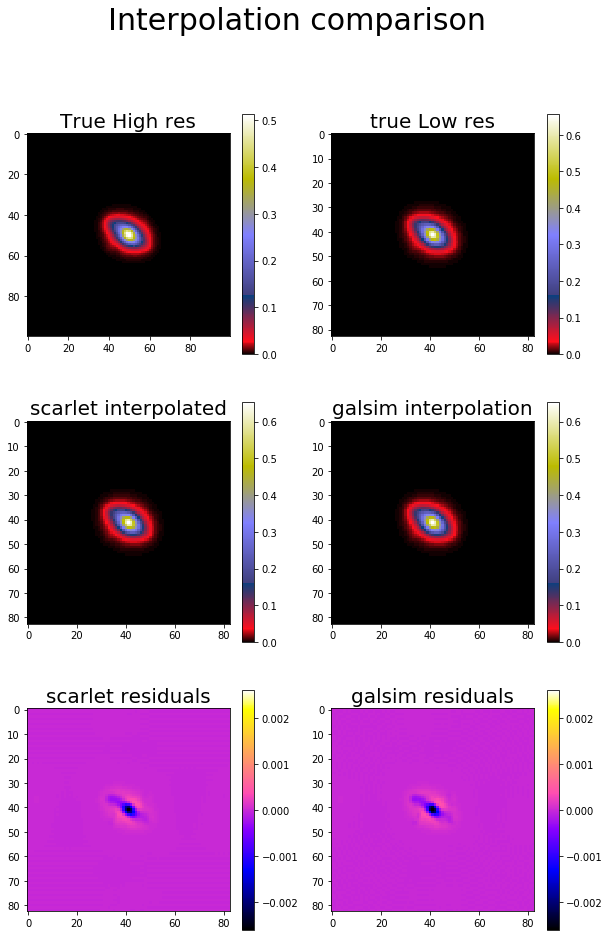

Scarlet timing
CPU times: user 204 ms, sys: 73.2 ms, total: 277 ms
Wall time: 121 ms
Galsim timing
CPU times: user 52.3 ms, sys: 67.2 ms, total: 120 ms
Wall time: 25 ms
scarlet SDR:  24.09323131122235
galsim SDR:  23.58349032845061


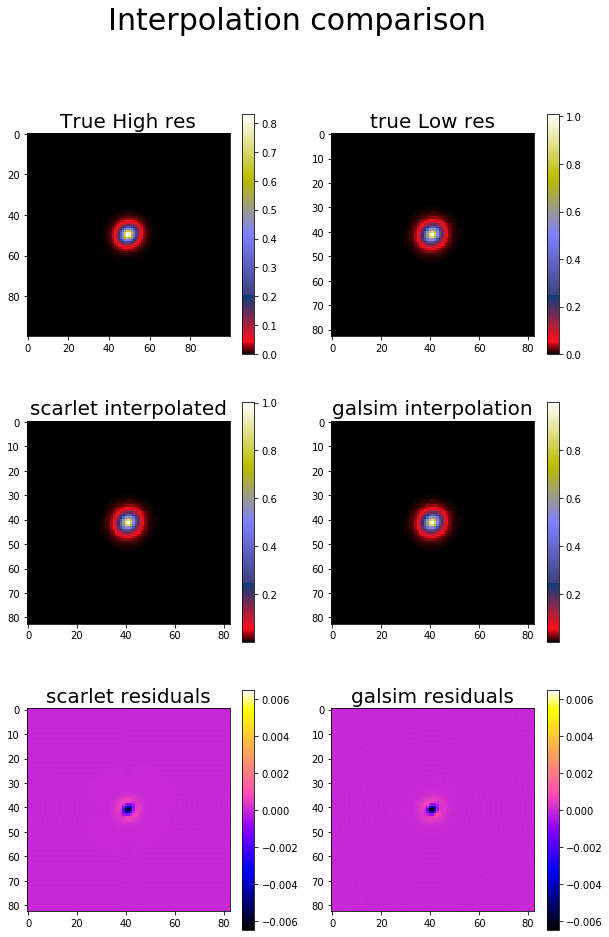

Scarlet timing
CPU times: user 201 ms, sys: 58.8 ms, total: 259 ms
Wall time: 114 ms
Galsim timing
CPU times: user 109 ms, sys: 26.8 ms, total: 135 ms
Wall time: 23.2 ms
scarlet SDR:  25.66532974980106
galsim SDR:  25.38320278373945


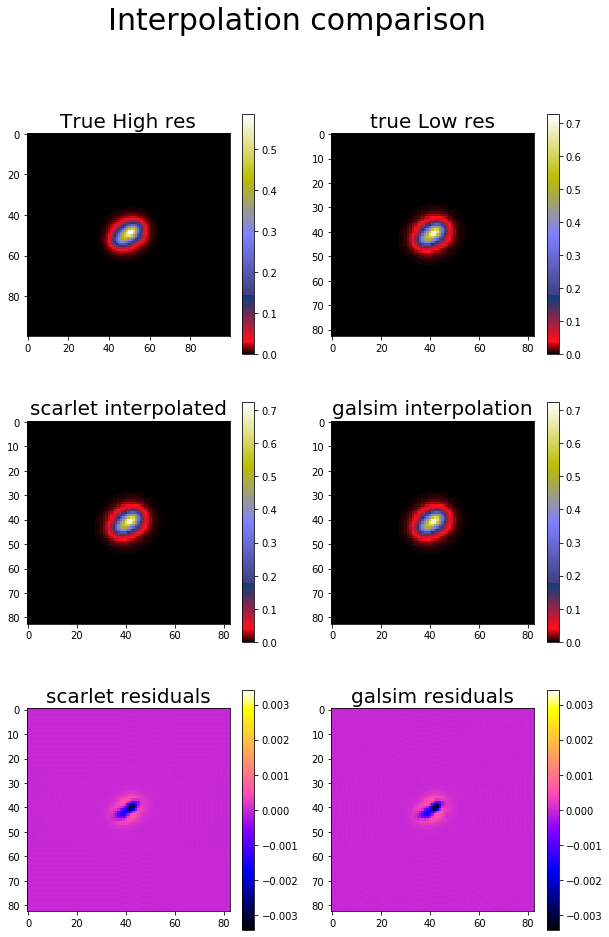

Scarlet timing
CPU times: user 192 ms, sys: 58.2 ms, total: 250 ms
Wall time: 109 ms
Galsim timing
CPU times: user 103 ms, sys: 26.7 ms, total: 130 ms
Wall time: 22.5 ms
scarlet SDR:  25.740917699046065
galsim SDR:  25.33160367393745


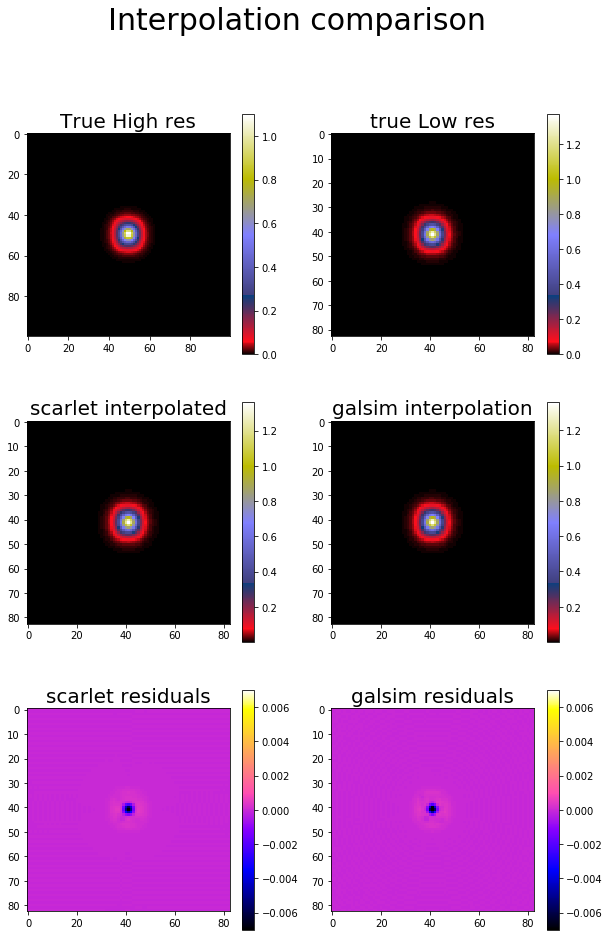

Scarlet timing
CPU times: user 189 ms, sys: 55.9 ms, total: 244 ms
Wall time: 106 ms
Galsim timing
CPU times: user 128 ms, sys: 29.1 ms, total: 158 ms
Wall time: 26.9 ms
scarlet SDR:  26.819921099475046
galsim SDR:  26.633983634682252


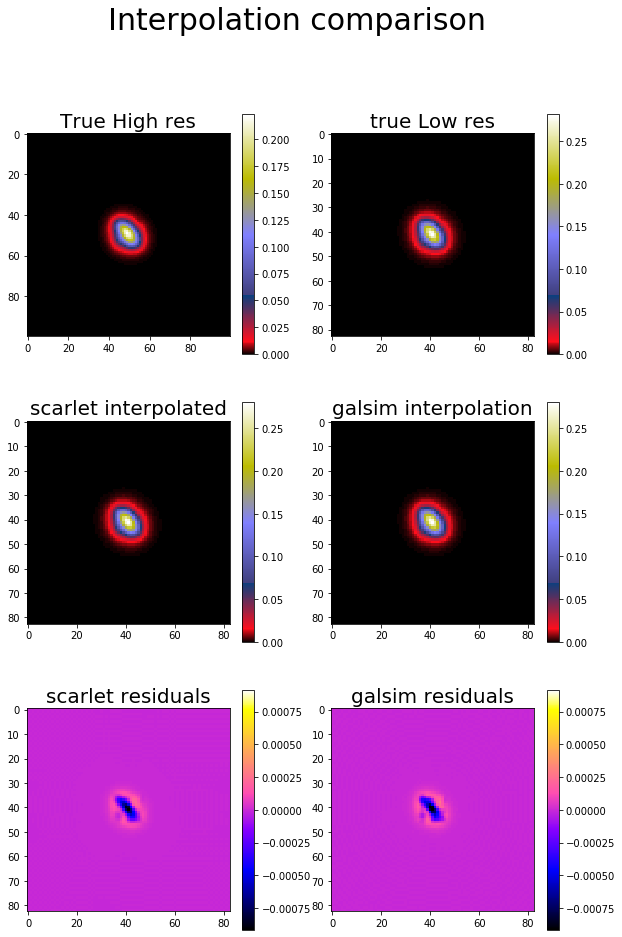

Scarlet timing
CPU times: user 178 ms, sys: 48.9 ms, total: 227 ms
Wall time: 98.5 ms
Galsim timing
CPU times: user 56.7 ms, sys: 62.2 ms, total: 119 ms
Wall time: 24.2 ms
scarlet SDR:  24.397737613922583
galsim SDR:  23.73337706312868


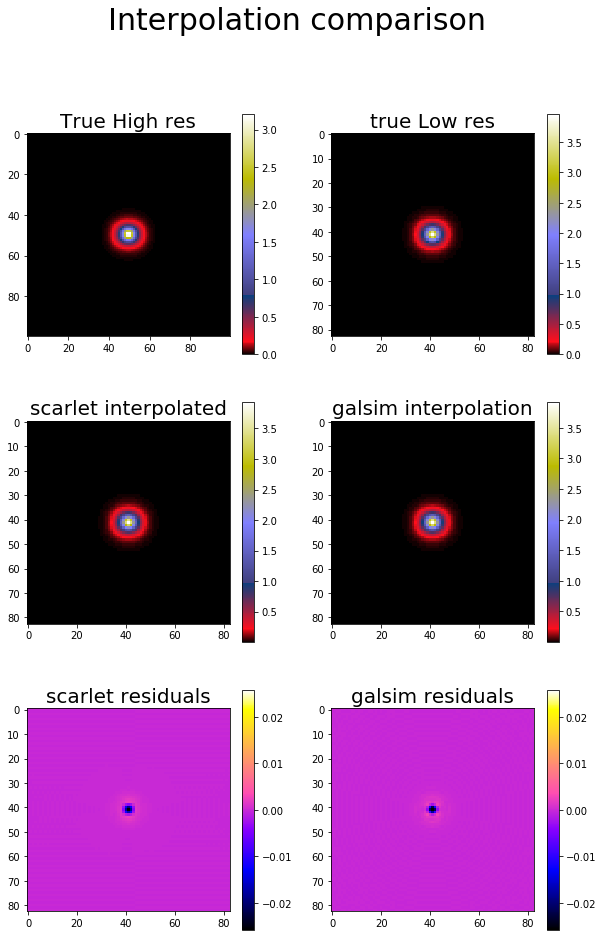

Scarlet timing
CPU times: user 177 ms, sys: 56 ms, total: 233 ms
Wall time: 101 ms
Galsim timing
CPU times: user 43.8 ms, sys: 70.1 ms, total: 114 ms
Wall time: 24.8 ms
scarlet SDR:  25.263637684993846
galsim SDR:  24.957527259833828


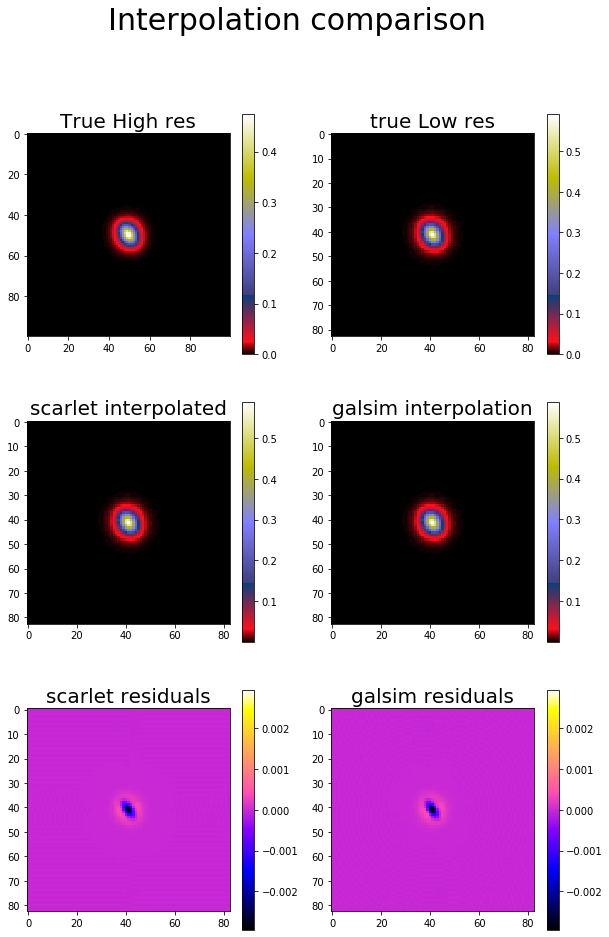

Scarlet timing
CPU times: user 189 ms, sys: 89.4 ms, total: 278 ms
Wall time: 129 ms
Galsim timing
CPU times: user 39.6 ms, sys: 78.8 ms, total: 118 ms
Wall time: 32.5 ms
scarlet SDR:  28.116651225050788
galsim SDR:  28.017129714546797


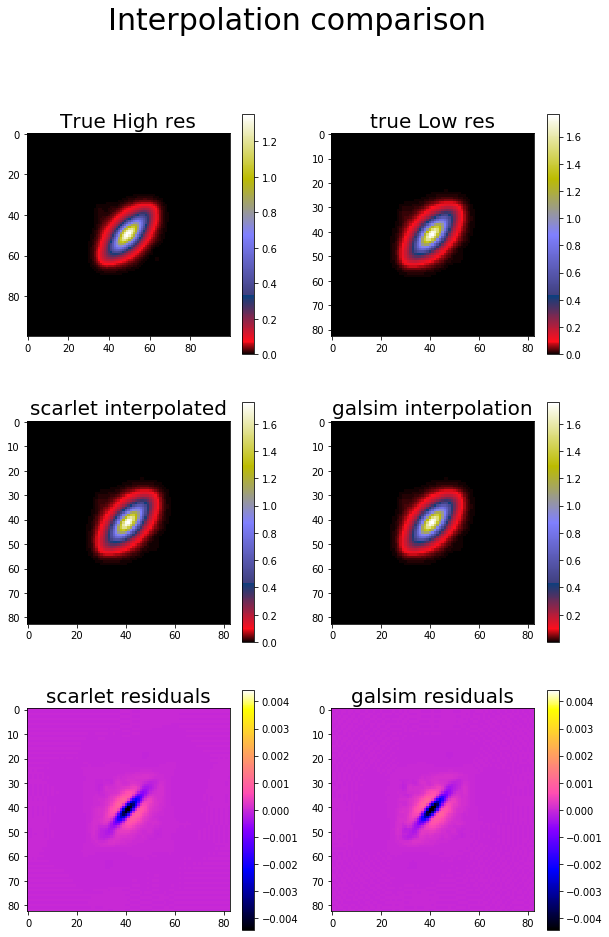

Scarlet timing
CPU times: user 199 ms, sys: 68.9 ms, total: 268 ms
Wall time: 117 ms
Galsim timing
CPU times: user 52.3 ms, sys: 81 ms, total: 133 ms
Wall time: 28.7 ms
scarlet SDR:  25.5822175651496
galsim SDR:  25.2207482233873


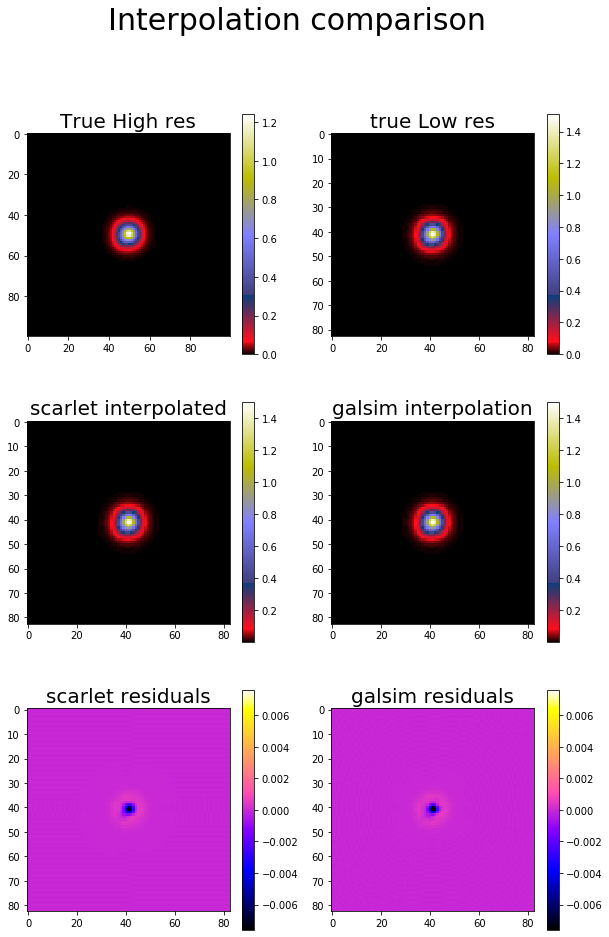

Scarlet timing
CPU times: user 199 ms, sys: 83.9 ms, total: 283 ms
Wall time: 126 ms
Galsim timing
CPU times: user 39.7 ms, sys: 95 ms, total: 135 ms
Wall time: 30.8 ms
scarlet SDR:  27.53759652321132
galsim SDR:  27.327126397741193


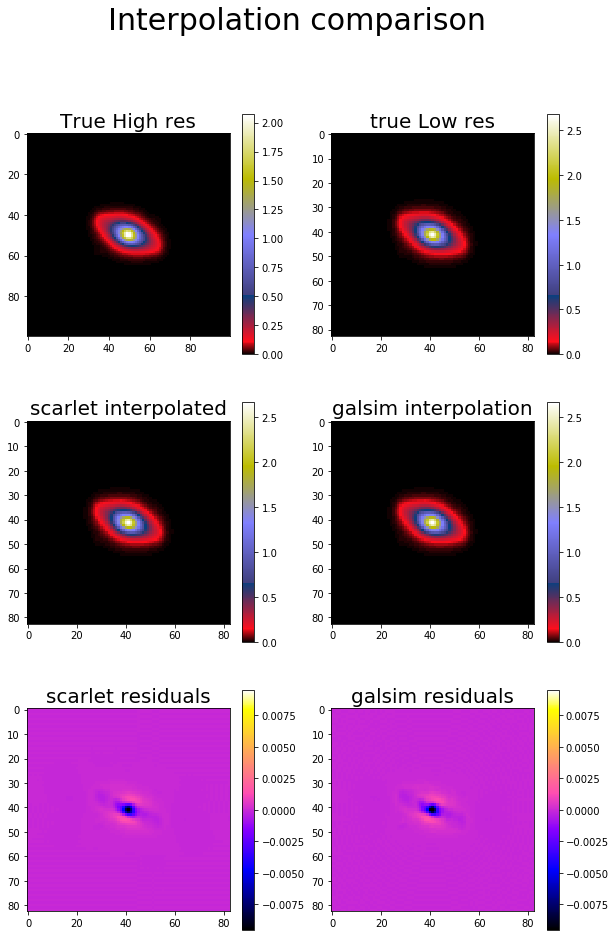

In [3]:
# Choose to surveys to match
survey_hr = HSC
survey_lr = LSST

# PSF size (pixels)
npsf = 41

# Size of the high resolution image (pixels)
n_hr = 100

# The low resolution image will span the same physical area
n_lr = np.around(n_hr*survey_hr['pixel']/survey_lr['pixel'])
# Channel names (scarlet-specific)
channel_hr = ['hr']
channel_lr = ['lr']
channels = channel_lr+channel_hr
c = 0
for i in range(39,50):    #[79,88]:#
    # Make the simulations
    data_hr, data_lr, psf_hr, psf_lr, angle = gct.mk_sim(i, survey_hr, survey_lr, (n_hr, n_hr), (n_lr, n_lr), npsf, cat)
    
    # Setup scarlet
    if c == 0:
        obs_lr, obs_hr = gct.setup_scarlet(data_hr, data_lr, psf_hr, psf_lr, channels)

    # Galsim setup:
    ## Interpolated image from psf_hr for galsim
    psf_hr_galsim = galsim.InterpolatedImage(galsim.Image(psf_hr[0]), 
                                               scale = survey_hr['pixel'])
    ## Deconvolution kernel for diff kernel
    deconv = galsim.Deconvolve(psf_hr_galsim)
    
    ## Interpolation of low resolution psf at high resolution from galsim
    psf_lr_hr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                               scale = survey_lr['pixel'])
    ## Difference kernel from galsim
    diff_gal = galsim.Convolve(deconv, psf_lr_hr)
    
    # Run scarlet on simulations:
    print('Scarlet timing')
    %time obs_lr.render(data_hr.array[None,:,:])
    interp_scar = obs_lr.render(data_hr.array[None,:,:])
    #interp_scar[interp_scar<0] = 0

    # Difference kernel from scarlet (for sanity checks)
    diff_scar = obs_lr.diff_psf
    
    # Run galsim on simlations
    print('Galsim timing')
    %time  gct.interp_galsim(data_hr, data_lr, diff_gal, angle, survey_hr['pixel'], survey_lr['pixel'])
    interp_gal = gct.interp_galsim(data_hr, data_lr, diff_gal, angle, survey_hr['pixel'], survey_lr['pixel'])
    
    # Check on the reconstruction of the PSF
    ## Reconstruction of the low resolution psf by galsim from hr psf and diff kernel (sanity check)
    rec_gal = galsim.Convolve(diff_gal, psf_hr_galsim).drawImage(nx=npsf,ny=npsf, scale=survey_hr['pixel'])
    
    ## True psf
    gal_lr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                      scale=survey_lr['pixel']).drawImage(nx=npsf,ny=npsf,scale=survey_hr['pixel']
                                                                         , method = 'real_space')
    
    ## Reconstruction of the low resolution psf by SCARLET from hr psf and diff kernl (sanity check)
    rec_scar = scarlet.fft.convolve(scarlet.fft.Fourier(psf_hr[0]), scarlet.fft.Fourier(diff_scar.image[0]))
    
    if c == 0:
        # Comparisonbetween scarlet and galsim of the reconstruction of the low resolution PSF at high resolution 
        r_scar=(gal_lr.array-rec_scar.image)
        figure(figsize = (15,5))
        plt.suptitle('comparison scarlet', fontsize = 20)
        subplot(131)
        title('scarlet PSF')
        imshow((rec_scar.image))
        plt.colorbar()
        subplot(132)
        title('true PSF')
        imshow((gal_lr.array))
        plt.colorbar()
        subplot(133)
        title('Residuals')
        imshow((r_scar), cmap = mymap, 
               vmin = -np.max(np.abs(r_scar)), vmax = np.max(np.abs(r_scar)))
        plt.colorbar()

        r_gal = (gal_lr.array-rec_gal.array)
        figure(figsize = (15,5))
        plt.suptitle('comparison galsim', fontsize = 20)
        subplot(131)
        title('galsim PSF')
        imshow((rec_gal.array))
        plt.colorbar()
        subplot(132)
        title('true PSF')
        imshow((gal_lr.array))
        plt.colorbar()
        subplot(133)
        title('Residuals')
        imshow((r_gal), cmap = mymap, 
               vmin = -np.max(np.max(r_gal)), vmax = np.max(np.max(r_gal)))
        plt.colorbar()
    
    # Source Distortion Ratio: the high the better
    print('scarlet SDR: ', gct.SDR(data_lr.array, interp_scar[0]))
    print('galsim SDR: ', gct.SDR(data_lr.array, interp_gal.array))
    
    # Comparison of the reconstructions 
    gal_res = data_lr.array-interp_gal.array
    scar_res = data_lr.array-interp_scar[0]
    figure(figsize = (10,15))
    plt.suptitle('Interpolation comparison', fontsize=30)
    subplot(321)
    title('True High res', fontsize = 20)
    imshow((data_hr.array))
    plt.colorbar()
    subplot(322)
    title('true Low res', fontsize = 20)
    imshow((data_lr.array))
    plt.colorbar()
    subplot(323)
    title('scarlet interpolated', fontsize = 20)
    imshow(np.abs(interp_scar[0]))
    plt.colorbar()
    subplot(324)
    title('galsim interpolation', fontsize = 20)
    imshow(np.abs(interp_gal.array))
    plt.colorbar()
    subplot(325)
    title('scarlet residuals', fontsize = 20)
    imshow(-(scar_res), cmap=mymap, vmin = -np.max(np.abs(scar_res)), vmax = np.max(np.abs(scar_res)))
    plt.colorbar()
    subplot(326)
    title('galsim residuals', fontsize = 20)
    imshow(-(gal_res), cmap=mymap, vmin = -np.max(np.abs(scar_res)), vmax = np.max(np.abs(scar_res)))
    plt.colorbar()
    show()
    
    c+=1
